In [2]:
# dependencies

import datetime
import pickle as pkl

import numpy as np
import pandas as pd
import pystan as stan
import matplotlib.pyplot as plt
import seaborn as sns

import xfx.mvglm.multinomial
import xfx.misc.plot

In [14]:
# helper functions

def package_cgibbs_samples(samples, factor_names, response_names):

    rfx_samples, prec_samples = zip(*samples)
    rfx_samples = [np.array(samples_) for samples_ in zip(*rfx_samples)]
    prec_samples = np.trace(prec_samples, axis1=2, axis2=3).T
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names, response_names, 'cGibbs'), package_prec_samples(prec_samples, factor_names, 'cGibbs')

def package_nuts_samples(samples, data, factor_names, response_names):

    alp0_samples = samples['intercept'][:, 0, :-1]
    alp_samples = [[alp_[:, lo:(hi+1)].T for lo, hi in zip(data['lo'] - 1, data['hi'] - 1)] for alp_ in samples['coefs'][:, 0, :-1]]
    rfx_samples = [np.array(samples_) for samples_ in zip(*[[alp0_[np.newaxis]] + alp_ for alp0_, alp_ in zip(alp0_samples, alp_samples)])]
    prec_samples = np.array([[np.trace(np.linalg.inv(tau__)) for tau__ in tau_] for tau_ in samples['cov_factor'][:, 0]]).T
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names, response_names, 'Stan/NUTS'), package_prec_samples(prec_samples, factor_names, 'Stan/NUTS')

def package_rfx_samples(rfx_samples, factor_names, response_names, algo_name):

    dfs = []
    for i, (samples_, factor_name) in enumerate(zip(rfx_samples, factor_names)):
        for j in range(samples_.shape[1]):
            df_ = pd.DataFrame(samples_[:, j].T, index=response_names)
            df_.index = df_.index.rename('response')
            df_.columns = df_.columns.rename('iter')
            df_['algo'] = algo_name
            df_['factor'] = factor_name
            df_['level'] = j
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['algo', 'factor', 'level', 'response'])
    return df

def package_prec_samples(prec_samples, factor_names, algo_name):

    df = pd.DataFrame(prec_samples, index=factor_names)
    df.index = df.index.rename('factor')
    df.columns = df.columns.rename('iter')
    df['algo'] = algo_name
    df = df.reset_index().set_index(['algo', 'factor'])
    return df

def est_acf(samples, n_lags):

    acf = samples.apply(lambda x: xfx.misc.plot.est_acf(x.values, n_lags), 1, False, 'expand')
    acf.columns = acf.columns.rename('lag')
    return acf

def est_ess(acfs, titer):
    
    df = pd.DataFrame(index=acfs.index)
    df['iat[iter]'] = acfs.apply(lambda x: xfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
    df['iat[sec]'] = df['iat[iter]'] * titer
    df['rate[iter]'] = 1 / (2 * df['iat[iter]'])
    df['rate[sec]'] = df['rate[iter]'] / titer
    return df

In [4]:
# config

factor_names = ['province_id', 'activity', 'age', 'education', 'municipality_size', 'voting_recall', 'gender']
response_names = ['conservatives', 'social_democrats']
exclude = ['abstention', 'invalid']
seed = 0

In [5]:
# construct

cis = pd.read_csv('paper/data/cis.csv')
cis = cis.loc[(cis.study_id == '2019-11-10') & (~cis.voting_intention.isin(exclude)) & (~cis.voting_intention.isna())]
cis['response'] = np.where(cis.voting_intention.isin(response_names), cis.voting_intention, '_others')
cis['voting_recall'] = np.where(cis.voting_recall.isin(response_names), cis.voting_recall, '_others')
cis = cis[factor_names + ['response']].dropna()
codes = cis.apply(lambda x: x.astype('category').cat.codes)
response = pd.get_dummies(codes.response)
indices = codes.drop('response', 1)
n_levels = np.max(indices, 0).astype(np.int64) + 1
rng = np.random.default_rng(seed)

In [6]:
# construct nuts inputs

counts = codes.groupby(codes.columns.tolist()).size().unstack('response').fillna(0)
coef_idx = counts.index.to_frame() + np.hstack([0, np.cumsum(n_levels[:-1])]) + 1
nuts_inputs = {
    'n_strata': counts.shape[0],
    'n_parties': counts.shape[1],
    'n_factors': len(n_levels),
    'n_coefs': n_levels.sum(),
    'prior_df': counts.shape[1] - 1,
    'lo': np.hstack([0, np.cumsum(n_levels[:-1])]) + 1,
    'hi': np.cumsum(n_levels).values,
    'coef_idx': coef_idx.values,
    'counts': counts.applymap(int).values}

In [ ]:
# sample nuts

nuts_n_samples = 1000
stan_model = stan.StanModel('paper/stan/xfx_mvlogit2.stan')
t0 = datetime.datetime.now()
nuts_sampler = stan_model.sampling(data=nuts_inputs, iter=2*nuts_n_samples, warmup=n_samples, chains=1, seed=0)
t1 = datetime.datetime.now()
nuts_titer = (t1 - t0).total_seconds() / stan_n_samples
nuts_leaps = nuts_sampler.get_sampler_params(inc_warmup=False)[0]['n_leapfrog__'].mean()
nuts_samples = nuts_sampler.extract(['intercept', 'coefs', 'cov_factor'], permuted=False)

In [7]:
# dump

with open('paper/output/stan_output.pkl', 'wb') as f:
    pkl.dump(nuts_samples, f)

print(nuts_titer, nuts_leaps)

4.463999181999999 334.346


In [24]:
# compute nuts summaries

#nuts_titer = 4.463999181999999
with open('paper/output/stan_output.pkl', 'rb') as f:
    nuts_samples = pkl.load(f)

nuts_rfx_samples, nuts_prec_samples = package_nuts_samples(nuts_samples, nuts_inputs, factor_names, response_names)
nuts_rfx_acf, nuts_prec_acf = (est_acf(samples_, 64) for samples_ in (nuts_rfx_samples, nuts_prec_samples))
nuts_rfx_ess, nuts_prec_ess = (est_ess(acfs_, nuts_titer) for acfs_ in (nuts_rfx_acf, nuts_prec_acf))

In [16]:
# construct cgibbs inputs

prior_n_tau = np.repeat(len(response_names), len(n_levels))
cgibbs_inputs = (response.values, n_levels.values, indices.values, None, prior_n_tau)

In [18]:
# sample cgibbs

cgibbs_n_samples = 10000
cgibbs_sampler = xfx.mvglm.multinomial.sample_posterior(*cgibbs_inputs, ome=rng)
next(cgibbs_sampler)
t0 = datetime.datetime.now()
cgibbs_samples = [next(cgibbs_sampler) for _ in range(2 * cgibbs_n_samples)][cgibbs_n_samples:]
t1 = datetime.datetime.now()
cgibbs_titer = (t1 - t0).total_seconds() / cgibbs_n_samples

In [19]:
# cgibbs iteration time

print(cgibbs_titer)

0.0832239095


In [20]:
# compute cgibbs summaries

#cgibbs_titer = 0.07967317410000001
cgibbs_rfx_samples, cgibbs_prec_samples = package_cgibbs_samples(cgibbs_samples, factor_names, response_names)
cgibbs_rfx_acf, cgibbs_prec_acf = (est_acf(samples_, 256) for samples_ in (cgibbs_rfx_samples, cgibbs_prec_samples))
cgibbs_rfx_ess, cgibbs_prec_ess = (est_ess(acfs_, cgibbs_titer) for acfs_ in (cgibbs_rfx_acf, cgibbs_prec_acf))

In [25]:
# stack

rfx_acf = pd.concat([cgibbs_rfx_acf, nuts_rfx_acf])
prec_acf = pd.concat([cgibbs_prec_acf, nuts_prec_acf])
rfx_ess = pd.concat([cgibbs_rfx_ess, nuts_rfx_ess])
prec_ess = pd.concat([cgibbs_prec_ess, nuts_prec_ess])

In [16]:
# dump

rfx_acf.to_csv('paper/output/exact_benchmark_acf_rfx.csv')
prec_acf.to_csv('paper/output/exact_benchmark_acf_prec.csv')
rfx_ess.to_csv('paper/output/exact_benchmark_ess_rfx.csv')
prec_ess.to_csv('paper/output/exact_benchmark_ess_prec.csv')

In [3]:
# configure for export

import matplotlib
sns.set()
matplotlib.rcParams.update({
    'font.family': ['serif'],
    'font.serif': ['Latin Modern Roman'],
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'font.size': 10
})

rfx_acf = pd.read_csv('paper/output/exact_benchmark_acf_rfx.csv')
prec_acf = pd.read_csv('paper/output/exact_benchmark_acf_prec.csv')
rfx_ess = pd.read_csv('paper/output/exact_benchmark_ess_rfx.csv')
prec_ess = pd.read_csv('paper/output/exact_benchmark_ess_prec.csv')
cgibbs_titer, nuts_titer, nuts_leaps = 0.07967317410000001, 4.463999181999999, 334.346

In [5]:
# item 1

table1 = ess_alp.groupby(['factor', 'algo'])['rate[sec]'].agg([np.max, np.median, np.min])
table1.columns = ['alp_max[ess/sec]', 'alp_med[ess/sec]', 'alp_min[ess/sec]']
table1['tau[ess/sec]'] = ess_tau.set_index(['factor', 'algo'])['rate[sec]']
table1 = table1.reset_index()
table1['factor'] = table1.factor.astype('category').cat.codes
table1 = table1.round(2)
table1 = table1.set_index(['factor', 'algo']).fillna('-')
table1

alp_max[ess/sec]  alp_med[ess/sec]  alp_min[ess/sec]  \
factor algo                                                              
0      Stan/NUTS              0.18              0.16              0.15   
       cGibbs                21.25             20.79             20.33   
1      Stan/NUTS              0.09              0.08              0.07   
       cGibbs                 7.71              6.46              5.47   
2      Stan/NUTS              0.12              0.11              0.09   
       cGibbs                 5.43              5.14              4.34   
3      Stan/NUTS              0.14              0.13              0.12   
       cGibbs                 5.30              4.38              3.49   
4      Stan/NUTS              0.12              0.11              0.10   
       cGibbs                 4.85              4.39              3.91   
5      Stan/NUTS              0.13              0.10              0.07   
       cGibbs                 6.02              5.48              5.09   
6      Stan/NUTS              0.34              0.22              0.12   
       cGibbs                10.37              4.35              1.73   
7      Stan/NUTS              0.11              0.10              0.09   
       cGibbs                 3.71              3.39              3.08   

                 tau[ess/sec]  
factor algo                    
0      Stan/NUTS            -  
       cGibbs               -  
1      Stan/NUTS         0.19  
       cGibbs           10.89  
2      Stan/NUTS         0.18  
       cGibbs            9.53  
3      Stan/NUTS         0.23  
       cGibbs            9.39  
4      Stan/NUTS         0.19  
       cGibbs            9.56  
5      Stan/NUTS         0.19  
       cGibbs           10.67  
6      Stan/NUTS         0.13  
       cGibbs            2.31  
7      Stan/NUTS         0.19  
       cGibbs            9.62

In [6]:
print(table1.to_latex())

\begin{tabular}{llrrrl}
\toprule
  &        &  alp\_max[ess/sec] &  alp\_med[ess/sec] &  alp\_min[ess/sec] & tau[ess/sec] \\
factor & algo &                   &                   &                   &              \\
\midrule
0 & Stan/NUTS &              0.18 &              0.16 &              0.15 &            - \\
  & cGibbs &             21.25 &             20.79 &             20.33 &            - \\
1 & Stan/NUTS &              0.09 &              0.08 &              0.07 &         0.19 \\
  & cGibbs &              7.71 &              6.46 &              5.47 &        10.89 \\
2 & Stan/NUTS &              0.12 &              0.11 &              0.09 &         0.18 \\
  & cGibbs &              5.43 &              5.14 &              4.34 &         9.53 \\
3 & Stan/NUTS &              0.14 &              0.13 &              0.12 &         0.23 \\
  & cGibbs &              5.30 &              4.38 &              3.49 &         9.39 \\
4 & Stan/NUTS &              0.12 &              0

In [7]:
# item 2

table2 = ess_alp.groupby(['algo'])['rate[sec]'].agg([np.max, np.median, np.min])
table2.columns = ['alp_max[ess/sec]', 'alp_med[ess/sec]', 'alp_min[ess/sec]']
table2['tau_med[ess/sec]'] = ess_tau.groupby(['algo'])['rate[sec]'].agg([np.median])
table2['runtime[sec/iter]'] = [xfx_titer, stan_titer]
table2['effort[leaps/iter]'] = ['-', np.round(stan_leaps, 2)]
table2.round(2)

,alp_max[ess/sec],alp_med[ess/sec],alp_min[ess/sec],tau_med[ess/sec],runtime[sec/iter],effort[leaps/iter]
algo,,,,,,
Stan/NUTS,0.34,0.20,0.07,0.19,0.08,-
cGibbs,21.25,4.58,1.73,9.56,4.46,334.35


In [8]:
print(table2.round(2).to_latex())

\begin{tabular}{lrrrrrl}
\toprule
{} &  alp\_max[ess/sec] &  alp\_med[ess/sec] &  alp\_min[ess/sec] &  tau\_med[ess/sec] &  runtime[sec/iter] & effort[leaps/iter] \\
algo      &                   &                   &                   &                   &                    &                    \\
\midrule
Stan/NUTS &              0.34 &              0.20 &              0.07 &              0.19 &               0.08 &                  - \\
cGibbs    &             21.25 &              4.58 &              1.73 &              9.56 &               4.46 &             334.35 \\
\bottomrule
\end{tabular}



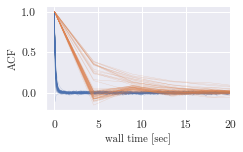

In [5]:
acf = pd.concat([rfx_acf, prec_acf]).melt(id_vars=['algo', 'factor', 'level', 'response'], var_name='lag')
acf['level'] = acf.level.fillna(0)
acf['factor'] = acf.factor.astype('category').cat.codes
acf['group'] = (acf.factor.astype('str') + '-' + acf.level.astype('str')).astype('category').cat.codes
acf['time'] = acf.lag.astype(int) * np.where(acf.algo == 'cGibbs', cgibbs_titer, nuts_titer)
#acf = acf.loc[~((acf.lag.astype(int) > 10) & (acf.lag.astype(int) % 10 != 0))]

g = sns.relplot(data=acf, x='time', y='value', hue='algo', kind='line', style='group', dashes=False, markers=False, legend=False, height=2, aspect=8/5, ci=None, alpha=1/3, lw=1/3)
plt.xlim(-1, 20)
g.set(xlabel='wall time [sec]', ylabel='ACF')
g.set_titles(col_template='{col_name}')
plt.savefig('paper/plots/crossed_exact_benchmark_acf.pdf', bbox_inches='tight')

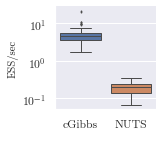

In [4]:
ess = pd.concat([rfx_ess, prec_ess])
ess['level'] = ess.level.fillna(0)
ess = ess.replace('Stan/NUTS', 'NUTS')

g = sns.catplot(data=ess, x='algo', y='rate[sec]', kind='box', order=['cGibbs', 'NUTS'], height=2, aspect=1, linewidth=1, fliersize=1, sym='o')
g.set(xlabel='$\\quad$', ylabel='ESS/sec')
plt.yscale('log')
plt.savefig('paper/plots/crossed_exact_benchmark_ess.pdf', bbox_inches='tight')